## Business Objective and Context.

Safety especially on the road is a paramount to all stakeholders. To ensure that the roads are safe for users, it is important to understand the factors that contribute to road accidents.

The aim is to build a model that predict the severity of accidents in the UK. The model will answer questions such as "What types of road lead to more accidents?" and "What kind of weather conditions are cars more susceptible to accidents?". This would allow Urban planners to corrobate safety of roads by examining what road types are more susceptible to accidents, Health and Safety responders would also be able to leverage on severity predictions to estimate the potential impacts of an accident and implement efficient response procedures.

The predictive model will use Accident Severity as the Dependent Variable and road type, junction detail, junction control, number of vehicles, lighting and weather conditions as the Independent Variables.

In [5]:
# Modules and Libraries Importation

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sbn
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from warnings import filterwarnings
filterwarnings("ignore")

## Data Selection and loading

In [6]:
# Laad the training and testing sets into a DataFrame object

training_set = pd.read_csv('../trainset.csv', index_col=0)
testing_set = pd.read_csv('../testset.csv', index_col=0)

In [7]:
training_set.head()

,number_of_vehicles,number_of_casualties,One way street,Roundabout,Single carriageway,Slip road,Mini-roundabout,More than 4 arms (not roundabout),Not at junction or within 20 metres,Other junction,...,Frost or ice,Snow,Wet or damp,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,accident_severity
0,-1.232373,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,1.146407,-0.233199,...,-0.092201,-0.039906,-0.635123,2.479504,-0.396389,-0.357648,-0.426571,-0.411835,-0.418664,Serious
1,1.711627,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,-0.233199,...,-0.092201,-0.039906,-0.635123,-0.403307,-0.396389,-0.357648,-0.426571,2.428155,-0.418664,Slight
2,0.239627,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,-0.233199,...,-0.092201,-0.039906,1.574498,-0.403307,-0.396389,-0.357648,-0.426571,2.428155,-0.418664,Slight
3,-1.232373,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,1.146407,-0.233199,...,-0.092201,-0.039906,-0.635123,-0.403307,2.522774,-0.357648,-0.426571,-0.411835,-0.418664,Slight
4,0.239627,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,-0.233199,...,-0.092201,-0.039906,-0.635123,-0.403307,-0.396389,-0.357648,-0.426571,2.428155,-0.418664,Serious


In [8]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72959 entries, 0 to 72958
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   number_of_vehicles                   72959 non-null  float64
 1   number_of_casualties                 72959 non-null  float64
 2   One way street                       72959 non-null  float64
 3   Roundabout                           72959 non-null  float64
 4   Single carriageway                   72959 non-null  float64
 5   Slip road                            72959 non-null  float64
 6   Mini-roundabout                      72959 non-null  float64
 7   More than 4 arms (not roundabout)    72959 non-null  float64
 8   Not at junction or within 20 metres  72959 non-null  float64
 9   Other junction                       72959 non-null  float64
 10  Private drive or entrance            72959 non-null  float64
 11  T or staggered junction     

In [9]:
testing_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18240 entries, 0 to 18239
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   number_of_vehicles                   18240 non-null  float64
 1   number_of_casualties                 18240 non-null  float64
 2   One way street                       18240 non-null  float64
 3   Roundabout                           18240 non-null  float64
 4   Single carriageway                   18240 non-null  float64
 5   Slip road                            18240 non-null  float64
 6   Mini-roundabout                      18240 non-null  float64
 7   More than 4 arms (not roundabout)    18240 non-null  float64
 8   Not at junction or within 20 metres  18240 non-null  float64
 9   Other junction                       18240 non-null  float64
 10  Private drive or entrance            18240 non-null  float64
 11  T or staggered junction     

In [10]:
# We split the data into predictors and target.

trainset_predictors = training_set.drop("accident_severity", axis=1)
trainset_target = training_set["accident_severity"].copy()

testset_predictors = testing_set.drop("accident_severity", axis=1)
testset_target = testing_set["accident_severity"].copy()

In [11]:
trainset_predictors.corr()

,number_of_vehicles,number_of_casualties,One way street,Roundabout,Single carriageway,Slip road,Mini-roundabout,More than 4 arms (not roundabout),Not at junction or within 20 metres,Other junction,...,Flood over 3cm. deep,Frost or ice,Snow,Wet or damp,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
number_of_vehicles,1.000000,0.197057,-0.023329,0.019793,-0.064456,0.013019,0.005991,0.002942,-0.062921,-0.009982,...,-0.027105,-0.034842,-0.007148,-0.037097,0.002652,-0.012264,-0.009676,0.004945,-0.000440,0.014121
number_of_casualties,0.197057,1.000000,-0.031382,-0.032673,-0.021545,0.014368,-0.013830,-0.000552,0.028459,-0.017519,...,0.008394,-0.000243,0.003932,0.036915,-0.004506,0.023937,0.025132,-0.014564,-0.012886,-0.009871
One way street,-0.023329,-0.031382,1.000000,-0.036561,-0.259387,0.015108,-0.013113,0.012414,-0.027677,0.025538,...,-0.004673,-0.008440,-0.003518,-0.012380,-0.007133,0.000915,-0.000837,0.007352,-0.005942,0.001728
Roundabout,0.019793,-0.032673,-0.036561,1.000000,-0.369841,-0.033873,-0.035918,-0.035237,-0.258904,-0.069216,...,-0.006950,-0.014725,-0.004277,-0.005538,-0.002374,0.002038,0.007148,-0.003394,0.003483,0.002685
Single carriageway,-0.064456,-0.021545,-0.259387,-0.369841,1.000000,-0.125649,-0.059319,-0.026828,0.038105,0.034724,...,-0.027787,0.021501,-0.002062,-0.011605,-0.001299,0.004312,-0.005905,0.000971,0.001652,-0.008051
Slip road,0.013019,0.014368,0.015108,-0.033873,-0.125649,1.000000,-0.013810,-0.013548,-0.099548,-0.026613,...,-0.002546,-0.001207,-0.001500,0.006556,-0.001833,-0.002262,0.001391,0.001212,0.004139,0.001403
Mini-roundabout,0.005991,-0.013830,-0.013113,-0.035918,-0.059319,-0.013810,1.000000,-0.014366,-0.105558,-0.028220,...,-0.005529,-0.006129,-0.004829,-0.003217,0.000558,-0.000666,0.001661,0.000284,0.004015,-0.001950
More than 4 arms (not roundabout),0.002942,-0.000552,0.012414,-0.035237,-0.026828,-0.013548,-0.014366,1.000000,-0.103557,-0.027685,...,-0.005424,-0.009665,0.001140,-0.004517,0.000385,0.000448,-0.008490,-0.000034,0.006303,0.002884
Not at junction or within 20 metres,-0.062921,0.028459,-0.027677,-0.258904,0.038105,-0.099548,-0.105558,-0.103557,1.000000,-0.203417,...,0.042065,0.043961,0.020748,0.020684,0.002672,0.008491,0.017343,-0.002102,-0.004139,-0.010233
Other junction,-0.009982,-0.017519,0.025538,-0.069216,0.034724,-0.026613,-0.028220,-0.027685,-0.203417,1.000000,...,-0.006578,-0.009300,-0.007751,-0.009944,-0.006332,-0.007231,-0.005032,-0.004175,0.004280,0.009184


#### Correlation between the independent variables is very low hence it's highly unlikely we have a multicollinearity or numerical problem.

## Feature Selection

There are 34 predictors and its imperative to extract the important features and exclude the least important ones. This way our models will get simplified and can understand better the most relevant predictors and get better results. Recursive Feature Elimination is used with a Logistic Regression model to select the 10 most important features.


In [12]:
# Using Recursive Feature Elimination

from sklearn.feature_selection import RFE
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(trainset_predictors, trainset_target)
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Selected Features: [ True  True  True  True False False False False  True False False False
  True False False False  True  True False False  True False  True False
 False False False False False False False False False False False]
Feature Ranking: [ 1  1  1  1  9 17  2 10  1 22  4  3  1 11  7 12  1  1 13 26  1 14  1 23
 19 21 20 15  6 16  8  5 18 24 25]


In [13]:
# Show the selected features.
selected_features = []
for item in fit.get_feature_names_out():
    selected_features.append(item)
print(selected_features)

['number_of_vehicles', 'number_of_casualties', 'One way street', 'Roundabout', 'Not at junction or within 20 metres', 'Auto traffic signal', 'Darkness - no lighting', 'Daylight', 'Other', 'Raining no high winds']


In [14]:
# Selecting the features.

trainset_predictors = trainset_predictors[selected_features]
testset_predictors = testset_predictors[selected_features]

In [15]:
# Verifying the shape.
trainset_predictors.shape

(72959, 10)

In [16]:
testset_predictors.shape

(18240, 10)

## Baseline

A simplistic baseline classifier will be used based on majority class i.e. finding the most common class label and always output as a prediction. 

In [17]:
# Class Label Distribution.
trainset_target.value_counts()

Slight     57220
Serious    14606
Fatal       1133
Name: accident_severity, dtype: int64

In [18]:
# Total size 
trainset_target.shape[0]

72959

The basleine will output "Slight" for all predictions. We will use macro-averaging in this project (precision, recall and F-score are evaluated in each class separately and then averaged across classes).

So if we apply the baseline classifier to all of the training set. 

For the "Slight" label, the accuracy measures will be:

* Precision: 57220/72959 = 0.784

* Recall: 57220/57220 = 1.0 

* F-score: 2/(1/precision + 1/recall) = 0.879

For the "Serious" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/14606 = 0.0

* F-score: 0.0

For the "Fatal" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/1133 = 0.0

* F-score: 0.0


The averages of the three classes, i.e. the eventual baseline scores:

* **Precision: 0.261**

* **Recall: 0.333**

* **F-score: 0.293**

## MODELLING AND TUNING

We will proceed with model building and tuning to derive the best possible model for the testing set. Due to the size of the data set and the computational power available, the following methods have been chosen for the process:

<ol>Gaussian Naive Bayes</ol>
<ol>K-Nearest Neighbors</ol>
<ol>Random  Forest</ol>
<ol>Support Vector Classifier</ol>

### Gaussian Naive Bayes

In [19]:
# Instantiate the Gaussian naive bayes model.

nb = GaussianNB()
nb_model = nb.fit(trainset_predictors, trainset_target)
nb_model

GaussianNB()

In [20]:
# Inspect the first 10 predictions

nb_model.predict(testset_predictors)[0:10]

array(['Slight', 'Slight', 'Slight', 'Slight', 'Slight', 'Slight',
       'Slight', 'Slight', 'Slight', 'Slight'], dtype='<U7')

In [21]:
nb_model.predict_proba(testset_predictors)[0:10]

array([[1.97553440e-02, 2.54547785e-01, 7.25696871e-01],
       [1.97553440e-02, 2.54547785e-01, 7.25696871e-01],
       [1.58573632e-33, 3.14562463e-05, 9.99968544e-01],
       [1.97553440e-02, 2.54547785e-01, 7.25696871e-01],
       [8.60743059e-05, 6.16887836e-02, 9.38225142e-01],
       [4.12248133e-02, 2.88196648e-01, 6.70578539e-01],
       [1.07292445e-02, 1.84169004e-01, 8.05101751e-01],
       [2.33276582e-02, 2.27188665e-01, 7.49483677e-01],
       [6.40243598e-03, 1.67262780e-01, 8.26334784e-01],
       [2.39872160e-01, 2.37012910e-01, 5.23114930e-01]])

In [22]:
testset_target[0:10]

0     Slight
1     Slight
2     Slight
3     Slight
4     Slight
5     Slight
6    Serious
7     Slight
8     Slight
9     Slight
Name: accident_severity, dtype: object

In [23]:
target_pred = nb_model.predict(testset_predictors)
f1_score(testset_target, target_pred, average='macro')

0.33683686457641526

The model yields a macro-averaged F-score of 33.68%, a 4.38% improvement over the baseline.

In [24]:
cross_val_score(nb_model, testset_predictors, testset_target, cv = 10).mean()

0.1162828947368421

### KNN

In [25]:
# Using K-nearest neighbour method

knn = KNeighborsClassifier()
knn_model = knn.fit(trainset_predictors, trainset_target)
knn_model

KNeighborsClassifier()

In [26]:
# Initial Prediction and accuracy.

target_predictions = knn_model.predict(testset_predictors)
f1_score(testset_target, target_predictions, average='macro')

0.3190009656669757

In [27]:
print(classification_report(testset_target, target_predictions))

              precision    recall  f1-score   support

       Fatal       0.01      0.01      0.01       258
     Serious       0.31      0.05      0.09      3749
      Slight       0.78      0.96      0.86     14233

    accuracy                           0.76     18240
   macro avg       0.37      0.34      0.32     18240
weighted avg       0.68      0.76      0.69     18240



### Hyper parameter tuning for KNN Classifier using GridSearchCV

In [28]:
knn_params = {"n_neighbors": np.arange(1,50)}
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(trainset_predictors, trainset_target)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [29]:
# Hyper Parameter tuning result shwoing the best score and optimal number of neighbours

print("Best Score: " +str(knn_cv.best_score_))
print("Best Parameters: " +str(knn_cv.best_params_))

Best Score: 0.7841527482173563
Best Parameters: {'n_neighbors': 45}


In [30]:
# Tuned KNN

knn_tuned = KNeighborsClassifier(11)
knn_tuned = knn_tuned.fit(trainset_predictors, trainset_target)

In [31]:
knn_tuned.score(testset_predictors, testset_target)

0.7753289473684211

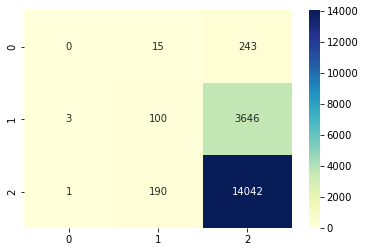

In [32]:
tuned_target_predictions = knn_tuned.predict(testset_predictors)
mat = confusion_matrix(testset_target, tuned_target_predictions)
p = sbn.heatmap(pd.DataFrame(mat), annot=True, cmap="YlGnBu" ,fmt='g')

In [33]:
# Accuracy after tuning

f1_score(testset_target, tuned_target_predictions, average='macro')

0.3074946989427089

### Random Forest and GridSearchCV for hyperparameter tuning.

In [34]:
import time

rf = RandomForestClassifier(random_state=2020)

# specify the hyperparameters and their values
# 4 x 3 x 2 = 24 combinations in the grid
param_grid_rf = {
    'n_estimators': [10, 100, 200, 1000],
    "max_features": [2,5,8,10],
    'max_depth': [2,3,5,8,10,15],
    'min_samples_split': [2, 5, 10]
}

# we'll use 5-fold cross-validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search_rf.fit(trainset_predictors, trainset_target)
end = time.time() - start
print(f"Took {end} seconds")

Took 28381.855078935623 seconds


In [35]:
grid_search_rf.best_estimator_

RandomForestClassifier(max_depth=15, max_features=5, n_estimators=10,
                       random_state=2020)

In [36]:
grid_search_rf.best_score_

0.30196049180967616

In [38]:
grid_search_rf.best_params_

{'max_depth': 15,
 'max_features': 5,
 'min_samples_split': 2,
 'n_estimators': 10}

In [39]:
grid_search_rf.cv_results_

{'mean_fit_time': array([1.65001106e-01, 1.32881813e+00, 2.44985027e+00, 8.43550615e+00,
        1.45673752e-01, 8.24212074e-01, 1.56933212e+00, 7.62192392e+00,
        1.48321915e-01, 9.47038984e-01, 1.55679250e+00, 8.05293169e+00,
        1.58353329e-01, 9.64722729e-01, 1.87142339e+00, 9.05660996e+00,
        1.56732655e-01, 1.00106301e+00, 1.90305362e+00, 9.03454108e+00,
        1.62838984e-01, 9.56949663e-01, 1.86030245e+00, 9.15579524e+00,
        1.74699354e-01, 1.10057902e+00, 2.15264573e+00, 1.14166214e+01,
        1.88030815e-01, 1.09006119e+00, 1.96803279e+00, 9.60360532e+00,
        1.60156536e-01, 1.03565078e+00, 1.97502761e+00, 1.08712656e+01,
        1.87059021e-01, 1.23435211e+00, 2.36474605e+00, 1.15679932e+01,
        1.78515196e-01, 1.20903978e+00, 2.44767733e+00, 1.15898105e+01,
        1.89340067e-01, 1.19703693e+00, 2.44057336e+00, 1.18761005e+01,
        1.49985123e-01, 8.57309580e-01, 1.76754103e+00, 8.30619278e+00,
        1.51133823e-01, 9.15439987e-01, 1.70621

## Tuned

In [40]:
# use the result of best_params_

rf_tuned = RandomForestClassifier(max_depth = 8, max_features = 5, min_samples_split = 2, n_estimators = 100)
rf_tuned.fit(trainset_predictors, trainset_target)

RandomForestClassifier(max_depth=8, max_features=5)

In [42]:
rf_tuned_pred = rf_tuned.predict(testset_predictors)
f1_score(testset_target, rf_tuned_pred, average='macro')

0.29463413513429676

In [43]:
best_model_index = grid_search_rf.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

252

In [44]:
rf_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search_rf.cv_results_[f"split{x}_test_score"][best_model_index]
    rf_split_test_scores.append(val)

In [45]:
cv_results = pd.DataFrame(grid_search_rf.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
252,"{'max_depth': 15, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 10}",0.319697,0.301960,5.547928e+00
243,"{'max_depth': 15, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 1000}",0.318384,0.301541,5.290105e+00
277,"{'max_depth': 15, 'max_features': 10, 'min_samples_split': 2, 'n_estimators': 100}",0.320128,0.301429,5.840992e+00
264,"{'max_depth': 15, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 10}",0.319662,0.301391,5.715551e+00
265,"{'max_depth': 15, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 100}",0.320149,0.301328,5.878660e+00
...,...,...,...,...
74,"{'max_depth': 3, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 200}",0.293032,0.293032,-2.212890e-08
75,"{'max_depth': 3, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 1000}",0.293032,0.293032,-2.212890e-08
76,"{'max_depth': 3, 'max_features': 8, 'min_samples_split': 5, 'n_estimators': 10}",0.293032,0.293032,-2.212890e-08
77,"{'max_depth': 3, 'max_features': 8, 'min_samples_split': 5, 'n_estimators': 100}",0.293032,0.293032,-2.212890e-08


In [46]:
feature_importances = grid_search_rf.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the trainset_predictors dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, trainset_predictors.columns), reverse=True):
    print(f"{v}: {k}")

number_of_vehicles: 0.3984784474736891
number_of_casualties: 0.24654782437260114
Darkness - no lighting: 0.056634872592167276
Auto traffic signal: 0.05229102957913023
Daylight: 0.0516955009954035
Not at junction or within 20 metres: 0.05137288350146557
Raining no high winds: 0.04879241592222392
Roundabout: 0.03434982002082545
Other: 0.032315254594026704
One way street: 0.027521950948467138


Text(0.5, 0, 'Variables Importance Ratio')

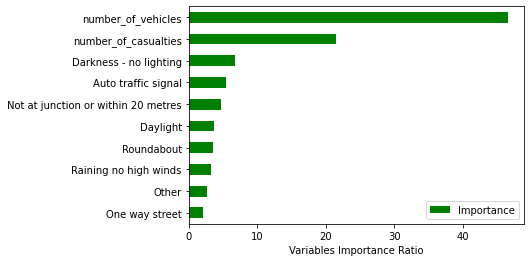

In [47]:
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                          index = trainset_predictors.columns)

Importance.sort_values(by = "Importance",
                       axis = 0,
                       ascending = True).plot(kind = "barh", color = "g")

plt.xlabel("Variables Importance Ratio")

In [ ]:
import os
from joblib import dump

# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search_rf.best_estimator_, 'models/rf-clf.joblib')

## Support Vector Machine

##    <i>i. Linear<i/>

In [ ]:
# Using Support Vector Classifier - DO NOT RUN

import time
from sklearn.svm import LinearSVC
linear_svm_model = LinearSVC(random_state=2020)

param_grid_linear = {
    'C': [0.001, 0.01, 0.1, 1, 3, 5],
    'max_iter': [5000] 
}

grid_search_linear = GridSearchCV(linear_svm_model, param_grid_linear, cv=5, scoring='f1_macro', return_train_score=True) 

start = time.time()
grid_search_linear.fit(trainset_predictors, trainset_target)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
grid_search_linear.best_estimator_

In [ ]:
grid_search_linear.best_score_

In [ ]:
cv_results = pd.DataFrame(grid_search_linear.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

In [ ]:
# Save model results

if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search_linear.best_estimator_, 'models/svm-linear-clf.joblib')

## <i>Polynomial SVM<i/>

In [ ]:
svm_poly = SVC(kernel="poly", gamma="scale", random_state=2020, degree=2)

# specify the hyperparameters and their values
param_grid_poly = {
    'C': [0.01, 0.1, 1, 10, 100],
}

# we'll use 5-fold cross-validation
grid_search_poly = GridSearchCV(svm_poly, param_grid_poly, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search_poly.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
grid_search_poly.best_estimator_

In [ ]:
grid_search_poly.best_score_

In [ ]:
cv_results = pd.DataFrame(grid_search_poly.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search_poly.best_estimator_, 'models/svm-poly-clf.joblib')

### RF

In [ ]:
# rf
rf_prediction = best_rf.predict(testset_predictors)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(testset_target, prediction, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

In [ ]:
ConfusionMatrixDisplay.from_predictions(testset_target, rf_prediction, labels=best_rf.classes_, 
                                        xticks_rotation="vertical", normalize="true")

### SVM linear

In [ ]:
svm_linear_prediction = best_svm.predict(testset_predictors)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(testset_target, prediction, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

In [ ]:
ConfusionMatrixDisplay.from_predictions(testset_target, svm_prediction, labels=best_svm.classes_, 
                                        xticks_rotation="vertical", normalize="true")

### SVM poly

In [ ]:
svm_poly_prediction = best_svm_poly.predict(testset_predictors)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(testset_target, prediction, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

In [ ]:
ConfusionMatrixDisplay.from_predictions(testset_target, svm_prediction, labels=best_svm.classes_, 
                                        xticks_rotation="vertical", normalize="true")

## Testing the models

In [ ]:
from joblib import load

best_rf = load("models/rf-clf.joblib")
best_svm = load("models/svm-linear-clf.joblib")
best_svm_poly = load("models/svm-poly-clf.joblib")